<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1">Описание проекта</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-2">Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-2.1">Вывод:</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-3">Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-3.1">Вывод:</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-4">Обучение моделей</a></span></li><li><span><a href="#Тестирование-моделей" data-toc-modified-id="Тестирование-моделей-5">Тестирование моделей</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-6">Общий вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf, pacf
import statsmodels.tsa.api as smt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA

from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

Приступаем к знакомству с данными:

In [2]:
try:
    data = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'])
except:
    data = pd.read_csv('taxi.csv', parse_dates=['datetime'])

In [3]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Всего 2 колонки. Дату мы перобразуем в индексы. И проанализируем данные:

In [5]:
data = data.set_index('datetime')

Теперь ресемплируем данные по 1 часу и агрегируем суммой:

In [6]:
data = data.resample('H').sum()

Посмотрим на среднее количество заказов на разных промежутках времени:

Text(0, 0.5, 'Количество заказов')

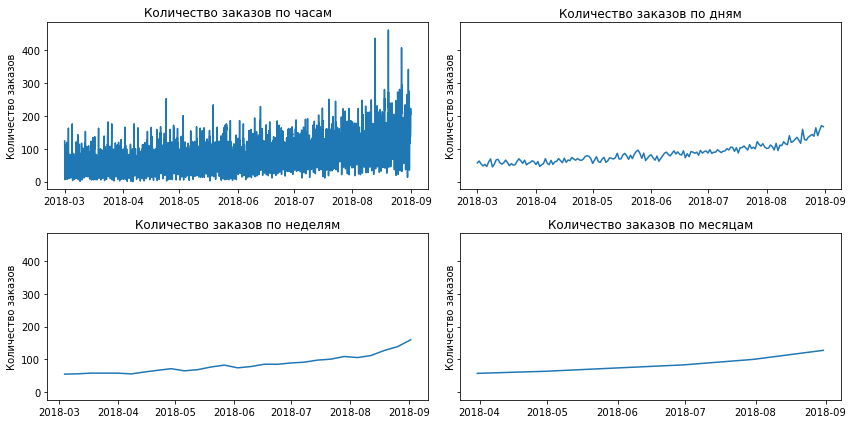

In [7]:
fig, axs = plt.subplots(2, 2, sharey=True, tight_layout=True, figsize=(12,6))
axs[0, 0].plot(data.resample('H').mean())
axs[0, 0].set_title('Количество заказов по часам')
axs[0, 0].set_ylabel('Количество заказов')

axs[0, 1].plot(data.resample('D').mean())
axs[0, 1].set_title('Количество заказов по дням')
axs[0, 1].set_ylabel('Количество заказов')

axs[1, 0].plot(data.resample('W').mean())
axs[1, 0].set_title('Количество заказов по неделям')
axs[1, 0].set_ylabel('Количество заказов')

axs[1, 1].plot(data.resample('M').mean())
axs[1, 1].set_title('Количество заказов по месяцам')
axs[1, 1].set_ylabel('Количество заказов')

Четко виден тренд на увеличение заказов. Кривая неуклонно растет. Следовательно, предварительно выдвину предположение, что временной ряд является нестационарным. Чуть позже проверим эту гипотезу.

**Работа с признаками**

Обогатим признаковое пространство. Добавим смещения и информацию о дне недели, месяце.

In [8]:
data['day'] = data.index.day
data['hour'] = data.index.hour
data['dayofweek'] = data.index.dayofweek
data['month'] = data.index.month

In [9]:
def create_lags(data, target_col, lags_list):
    for i in lags_list:
        data['lag_' + str(i)] = data[target_col].shift(i)
    return data

In [10]:
data = create_lags(data, 'num_orders', [1, 2, 3, 6, 12, 24, 48])

In [11]:
data.head()

,num_orders,day,hour,dayofweek,month,lag_1,lag_2,lag_3,lag_6,lag_12,lag_24,lag_48
datetime,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,0,3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,1,3,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,2,3,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,4,3,3,66.0,71.0,85.0,NaN,NaN,NaN,NaN


Теперь, добавим признак, который позволит модели лучше улавливать текущий внутридневной тренд. Для этого построим скользящую кривую, и для нее подберем руками значение окна: 

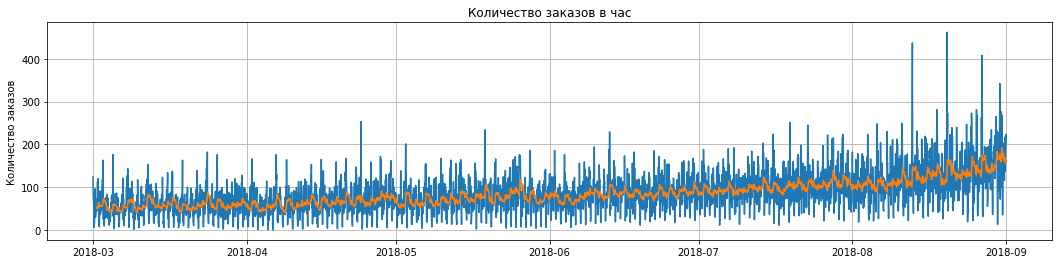

In [12]:
fig, ax = plt.subplots(figsize=(18,4))
ax.plot(data['num_orders'], label='num_orders')
ax.plot(data['num_orders'].rolling(20).mean(), label='rolling_curve')
ax.set_title('Количество заказов в час')
ax.set_ylabel('Количество заказов')
plt.grid(True)

- Выберем значение окна равное 5. Чтобы улавливать внутридневные тренды. 
- Значение окна равное 30 и 300 поможет нам улавливать общий растущий тренд.

Добавим новые признаки в датафрейм:

In [13]:
data['rolling_mean5'] = data['num_orders'].shift().rolling(5).mean()
data['rolling_mean30'] = data['num_orders'].shift().rolling(30).mean()
data['rolling_mean300'] = data['num_orders'].shift().rolling(300).mean()

Избавимся от появившихся пропусков:

In [14]:
data = data.dropna()

In [15]:
data.head()

,num_orders,day,hour,dayofweek,month,lag_1,lag_2,lag_3,lag_6,lag_12,lag_24,lag_48,rolling_mean5,rolling_mean30,rolling_mean300
datetime,,,,,,,,,,,,,,,
2018-03-13 12:00:00,34,13,12,1,3,75.0,53.0,44.0,15.0,91.0,45.0,50.0,49.8,60.066667,56.523333
2018-03-13 13:00:00,40,13,13,1,3,34.0,75.0,53.0,20.0,88.0,64.0,80.0,52.6,60.700000,56.223333
2018-03-13 14:00:00,50,13,14,1,3,40.0,34.0,75.0,57.0,58.0,58.0,72.0,49.2,61.400000,56.073333
2018-03-13 15:00:00,69,13,15,1,3,50.0,40.0,34.0,44.0,63.0,73.0,60.0,50.4,60.566667,56.003333
2018-03-13 16:00:00,64,13,16,1,3,69.0,50.0,40.0,53.0,42.0,61.0,93.0,53.6,59.366667,56.013333


Посмотрим на итоговую матрицу корреляции:

In [16]:
data.corr()

,num_orders,day,hour,dayofweek,month,lag_1,lag_2,lag_3,lag_6,lag_12,lag_24,lag_48,rolling_mean5,rolling_mean30,rolling_mean300
num_orders,1.000000,0.127121,-0.006439,-0.016319,0.497822,0.616525,0.452191,0.302636,0.227103,0.329391,0.686941,0.720543,0.481105,0.537231,0.546199
day,0.127121,1.000000,-0.001009,-0.003857,-0.118351,0.127100,0.126925,0.126554,0.126893,0.130069,0.122106,0.109074,0.167537,0.217419,0.158509
hour,-0.006439,-0.001009,1.000000,-0.002538,-0.004167,-0.089589,-0.129390,-0.161320,-0.066585,-0.077931,-0.006150,-0.005669,-0.172707,-0.038288,-0.007107
dayofweek,-0.016319,-0.003857,-0.002538,1.000000,-0.004165,-0.023619,-0.025916,-0.024409,-0.019496,-0.031456,0.037510,0.020786,-0.031631,0.006796,-0.018424
month,0.497822,-0.118351,-0.004167,-0.004165,1.000000,0.497747,0.497593,0.497671,0.496756,0.494607,0.493338,0.486738,0.657833,0.858160,0.927496
lag_1,0.616525,0.127100,-0.089589,-0.023619,0.497747,1.000000,0.615799,0.451692,0.215144,0.310855,0.549452,0.562135,0.687787,0.582951,0.550331
lag_2,0.452191,0.126925,-0.129390,-0.025916,0.497593,0.615799,1.000000,0.615556,0.229441,0.252306,0.390828,0.407731,0.789225,0.606707,0.551877
lag_3,0.302636,0.126554,-0.161320,-0.024409,0.497671,0.451692,0.615556,1.000000,0.301324,0.259309,0.246330,0.261428,0.828646,0.622052,0.553137
lag_6,0.227103,0.126893,-0.066585,-0.019496,0.496756,0.215144,0.229441,0.301324,1.000000,0.223121,0.195201,0.191762,0.479132,0.595849,0.552296
lag_12,0.329391,0.130069,-0.077931,-0.031456,0.494607,0.310855,0.252306,0.259309,0.223121,1.000000,0.325249,0.273920,0.370865,0.557163,0.548704


Многие признаки достаточно сильно коррелируют друг с другом. Однако полной корреляции близкой к 1 нет. Значит, можем использовать эти признаки в обучении.

### Вывод:

Данные изучены и подготовлены. 

- Временные ряды ресемплированы по одному часу.
- Обогащено признаковое пространство.

## Анализ

Проанализируем данные с точки зрения сезонности, трендов, и пр.

Посмотрим еще раз на распределение целевого признака в течение дня:

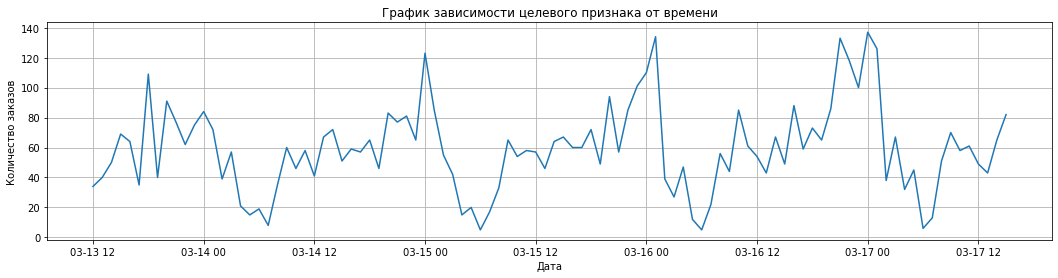

In [17]:
fig, ax = plt.subplots(figsize=(18,4))
ax.plot(data['num_orders'].iloc[0:100])
ax.set_title('График зависимости целевого признака от времени')
ax.set_ylabel('Количество заказов')
ax.set_xlabel('Дата')
plt.grid(True)
plt.show()

Наблюдается сильный разброс значений целевого признака в течение дня. Видна четкая сезонность внутри дня: пик в 00:00 часов, спад в утреннее время, и скачкообразный рост к полуночи.

Проверим ряд на стационарность с помощью теста Дики-Фуллера:

**Тест Дики-Фуллера**

- **Нулевая гипотеза**: ряд имеет единичный корень (не является стационарным) 

- **Альтернативная гипотеза**: ряд не имеет единичного корня (является стационарным)


In [18]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [19]:
adf_test(data.num_orders)

Results of Dickey-Fuller Test:
Test Statistic                   -3.016203
p-value                           0.033409
#Lags Used                       30.000000
Number of Observations Used    4085.000000
Critical Value (1%)              -3.431952
Critical Value (5%)              -2.862248
Critical Value (10%)             -2.567147
dtype: float64


**p-value = 0.029 < 0.05**, что вроде бы позволяет отвергнуть нулевую гипотезу, однако, такое утверждение не всегда справедливо. Посмотрим декомпозированный график временного ряда:

In [20]:
decomposed = seasonal_decompose(data.num_orders)

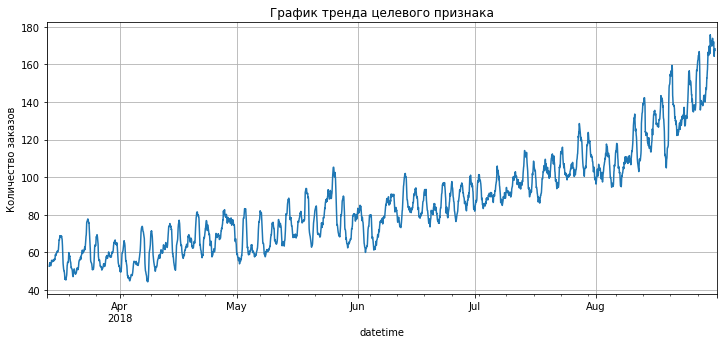

In [21]:
plt.figure(figsize=(12, 5))
decomposed.trend.plot()
plt.title('График тренда целевого признака')
plt.ylabel('Количество заказов')
plt.grid(True)

Несмотря на результаты теста Дики-Фуллера, мы видим, что количество заказов неуклонно растет! И снова, нам неизвестно, это сезонные годовые колебания или тренд. Полагаем, что **тренд является мультипликативным**, так как график тренда похож на экспоненциальный.

Посмотрим на сезонность:

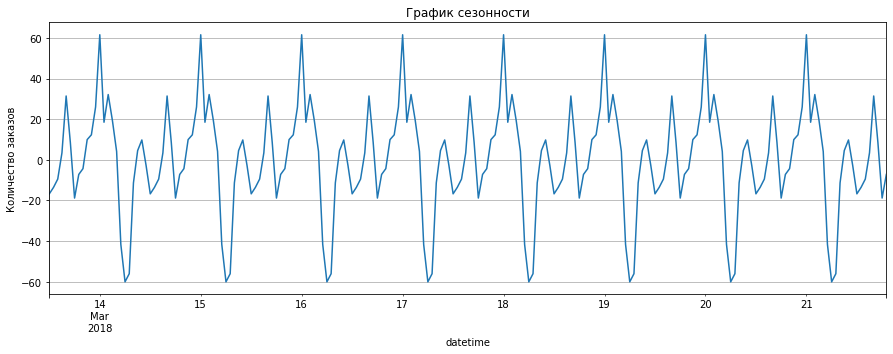

In [22]:
plt.figure(figsize=(15, 5))
decomposed.seasonal[:200].plot()
plt.title('График сезонности')
plt.ylabel('Количество заказов')
plt.grid(True)

Cезонность у нас есть, и выражена в рамках одного дня. День за днем картина повторяется.  Полагаем, что **сезонность - аддитивна.**

Это наблюдение в сумме с трендом на рост, и увеличивающейся к хвосту ряда дисперсией **не позволяет** нам **считать** этот **ряд стационарным.** 

### Вывод:

- В данных по количеству заказов сервиса такси - наблюдается тренд на увеличение заказов. Однако неизвестно, это сезонный тренд или постоянный в связи с недостатком данных. 
- Так же, выяснилась сезонность целевого признака в рамках одного дня. Пик в ночное время около 00:00, резкий спад в утренние часы, и новые меньшие пики в течение дня. 
- Проверена гипотеза о стационарности временного ряда. Результат -  **ряд не является стационарным**.

## Обучение моделей

Прежде чем приступать к обучению, подготовим данные. Отделим фичи от целевого признака, и создадим тестовую выборку:

In [23]:
features = data.drop('num_orders', axis=1)
target = data.num_orders

In [24]:
features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle=False, 
                                                                            test_size=0.1, random_state=42)

print('Проверка размерности:')
print('Исходный размер датафрейма:', data.shape)
print('Размер features_test:', features_test.shape)
print('Размер features_test:', features_train.shape)
print('Размер target_train:', target_train.shape)
print('Размер target_test:', target_test.shape)

Проверка размерности:
Исходный размер датафрейма: (4116, 15)
Размер features_test: (412, 14)
Размер features_test: (3704, 14)
Размер target_train: (3704,)
Размер target_test: (412,)


Для начала, напишем код для кросс-валидации. Стандартный подход к кросс-валидации мы на временном ряду использовать не можем, так как фолды будут перемешиваться и мы получим утечку целевого признака из будущего. Поэтому воспользуемся стратегией как на картинке ниже:

In [25]:
display(Image(url='https://habrastorage.org/files/f5c/7cd/b39/f5c7cdb39ccd4ba68378ca232d20d864.png'))

In [26]:
def cross_validation1(features, target, model, num_folds, params=None):
    scores = []
    batch = int(np.floor(features.shape[0] / num_folds))
    for i in range(num_folds-1):
        train_features = features.iloc[0:(i+1)*batch]
        test_features = features.iloc[(i+1)*batch+1:(i+1)*batch+batch]
        
        train_target = target.iloc[0:(i+1)*batch]
        test_target = target.iloc[(i+1)*batch+1:(i+1)*batch+batch]
        
        if params != None:
            estimator = GridSearchCV(model, params, scoring='neg_mean_squared_error')
        else:
            estimator = model 
            
        estimator.fit(train_features, train_target)
        
        if params != None:
            best_estimator = estimator.best_estimator_
        else:
            best_estimator = estimator
        
        predictions = best_estimator.predict(test_features)
        
        score = mean_squared_error(test_target, predictions)
        scores.append(score)
        
    # добавляем визуализацию результатов
    plt.figure(figsize=(15, 5))
    plt.plot(test_target.values[0:200], label="actual")
    plt.plot(predictions[0:200], "r", label="prediction")
    
    plt.legend(loc="best")
    plt.title("Best estimator (first 200 objects) \n Train / test sample shape {} / {} \n Root mean squared error {} orders per hour".format(
            train_features.shape[0], test_features.shape[0], round(np.sqrt(mean_squared_error(predictions, test_target)))))
    plt.grid(True);
    print('Средняя оценка RMSE на кросс-валидации:', np.sqrt(np.mean(scores)))
    
    # доучиваем модель теперь уже на всех тренировочных данных
    best_estimator = estimator.fit(features, target)
        
    return best_estimator 

**Модель линейной регрессии**

Средняя оценка RMSE на кросс-валидации: 26.65882950151272


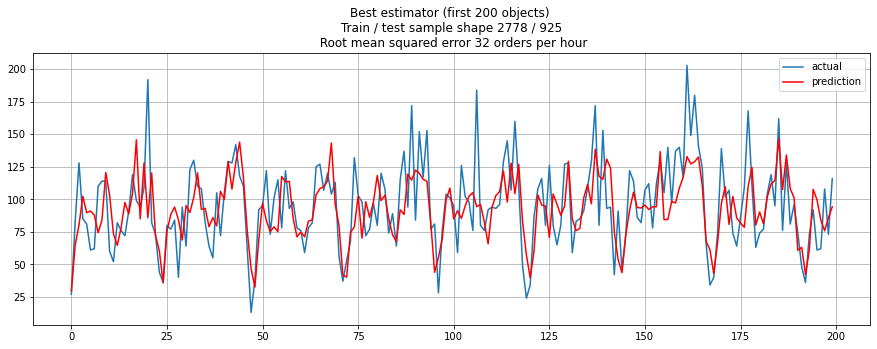

In [27]:
lr = cross_validation1(features_train, target_train, LinearRegression(), 4, None)

Видно, что нашей модели удается уловить закономерности в распределении данных. Она хорошо отлавливает ямы, но занижает прогноз пиковых значений.

**Модель случайного леса**

Средняя оценка RMSE на кросс-валидации: 27.087160928424055


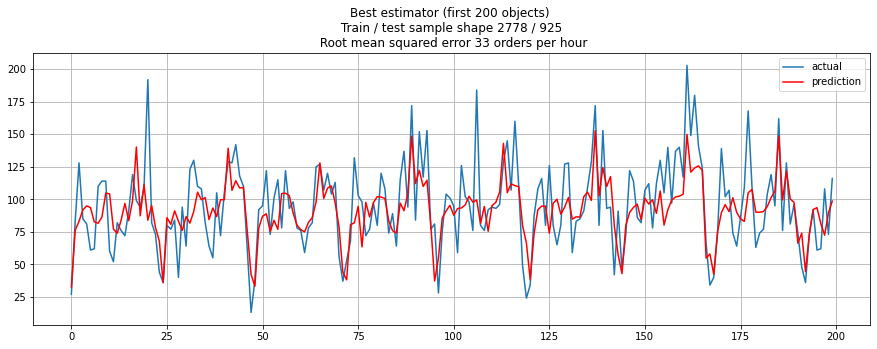

In [28]:
rf = cross_validation1(features_train, target_train, RandomForestRegressor(), 4, params={'max_depth':range(3, 6)})

Тоже хороший результат. Достаточно точные попадания в ямы, реже - близкие к пиковым значениям прогнозы. Не очень точное прогнозирование "серединных" значений. 

**Модель XGBoost**

Средняя оценка RMSE на кросс-валидации: 25.885709831624673


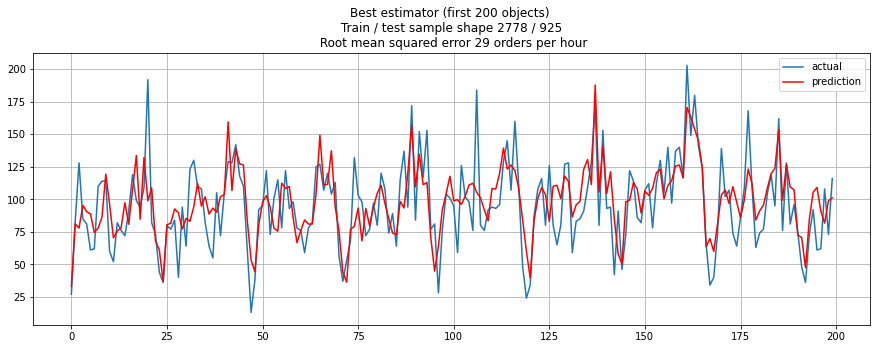

In [29]:
xgb = cross_validation1(features_train, target_train, XGBRegressor(), 4, {'n_estimators' : [10, 100, 500], 
                                                              'max_depth' : range(2, 5),
                                                              'learning_rate': [0.01, 0.1]})

На данный момент это лучший результат. Модель хорошо предсказывает данные. Неплохо справляется со спадами и подъемами, и чуть хуже с центром графика. Но общие закономерности модель поняла.

**Модель Хольта-Уинтерса**

Для ее обучения, нам нужно немножно скорректировать написанную выше функцию кросс-валидации:

In [30]:
def cross_validation_stat_models(target, num_folds):
    scores = []
    batch = int(np.floor(data.shape[0] / num_folds))
    for i in range(1, num_folds):
        train_target = target.iloc[0 : i*batch]
        test_target = target.iloc[i*batch : (i*batch)+batch]
        
        fit1 = ExponentialSmoothing(train_target, seasonal_periods=24, trend='add', seasonal='add', damped_trend=True,
                                ).fit()
        
        predictions = fit1.forecast(len(test_target))
        
        score = mean_squared_error(test_target, predictions)
        scores.append(score)
        
     # добавляем визуализацию результатов
    plt.figure(figsize=(15, 5))
    plt.plot(test_target[0:500], label="actual")
    plt.plot(predictions[0:500], "r", label="prediction")

    plt.legend(loc="best")
    plt.title("Best estimator (first 500 objects) \n Train / test sample shape {} / {} \n Root mean squared error {} orders per hour".format(
    train_target.shape[0], test_target.shape[0], round(np.sqrt(np.mean(scores)))))
    plt.grid(True);
    print('Средняя оценка RMSE на кросс-валидации:', np.sqrt(np.mean(scores)))
    
    fit1 = ExponentialSmoothing(target, seasonal_periods=24, trend='add', seasonal='add', damped_trend=True,
                                ).fit()
        
    return fit1


Средняя оценка RMSE на кросс-валидации: 28.559438668678016


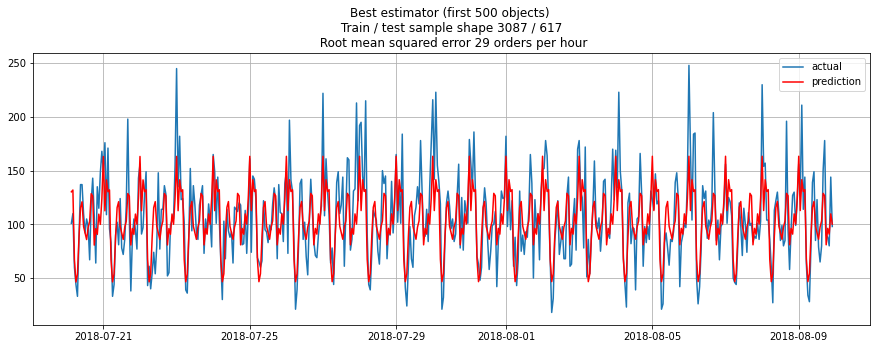

In [31]:
hw = cross_validation_stat_models(target_train, 4)


Модель Хольта-Уинтерса показала самый слабый результат. В среднем, ошибка на 29 заказов. Посмотрим, как она покажет себя на тесте.

## Тестирование моделей

LinearRegression RMSE test score: 44.935


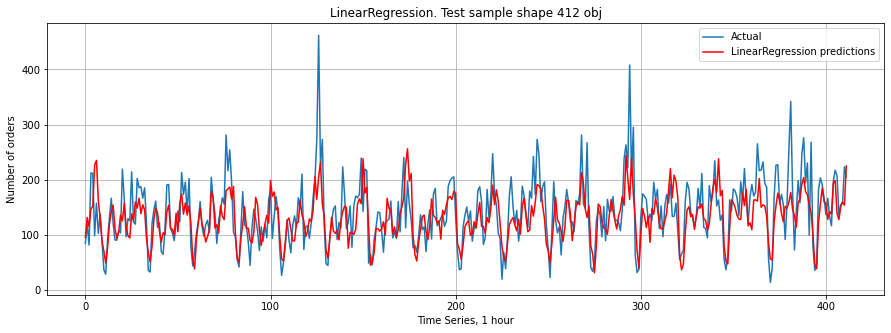

RandomForest RMSE test score: 46.258


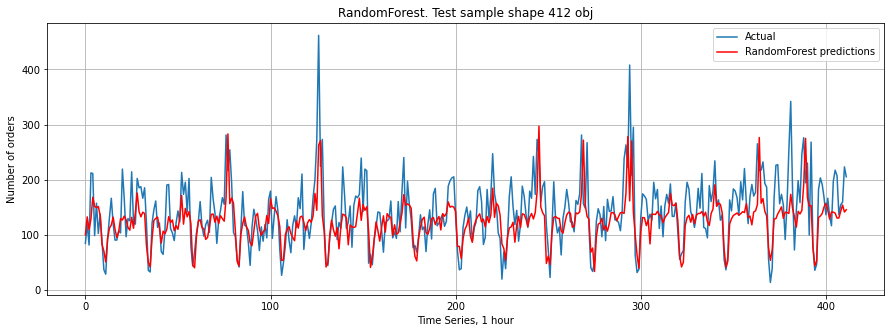

Holt-Winters RMSE test score: 45.797


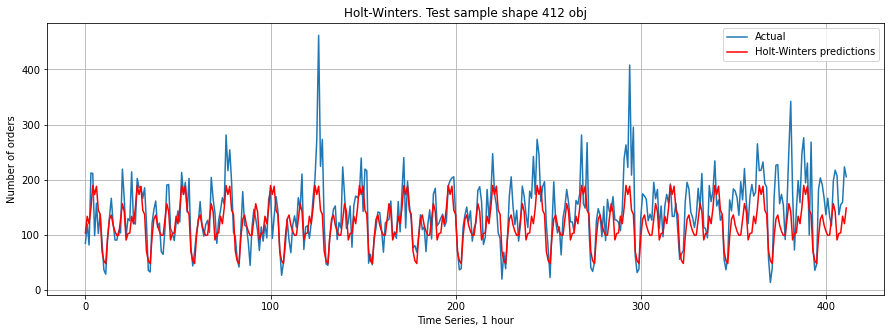

XGBoost RMSE test score: 41.441


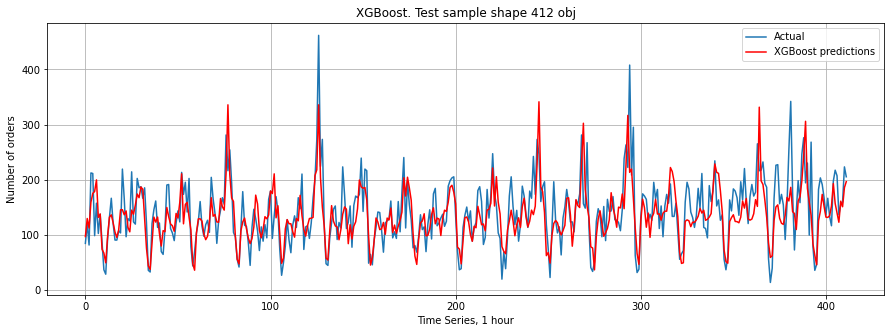

Dummy-model RMSE test score: 59.421


Text(0.5, 0, 'Time Series, 1 hour')

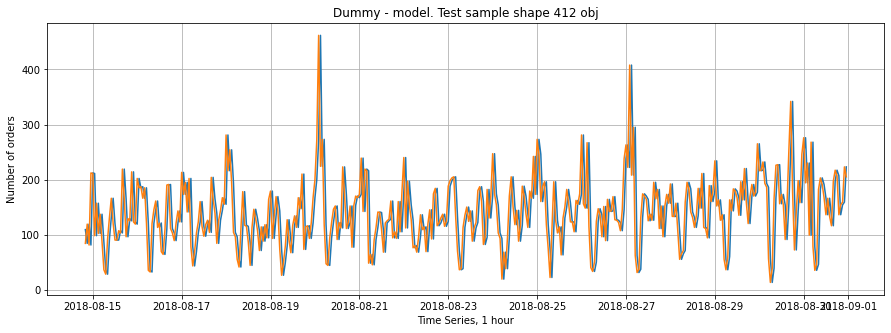

In [32]:
models = {'LinearRegression':lr, 'RandomForest':rf, 'Holt-Winters':hw, 'XGBoost': xgb}

for model_name, model in models.items():
    if model_name != 'Holt-Winters':
        predictions = model.predict(features_test)
        score = np.sqrt(mean_squared_error(target_test, predictions))
    else:
        predictions = model.forecast(len(target_test)).values
        score = np.sqrt(mean_squared_error(target_test, predictions))
    print(model_name, 'RMSE test score: %.3f' %score)
    
    plt.figure(figsize=(15, 5))
    plt.title(model_name + ". Test sample shape " + str(target_test.shape[0]) + ' obj')
    plt.plot(target_test.values, label='Actual')
    plt.plot(predictions, label=model_name+' predictions', c='r')
    plt.legend(loc="best")
    plt.grid(True)
    plt.ylabel('Number of orders')
    plt.xlabel('Time Series, 1 hour')
    plt.show()
    
# Добавляем Dummy модель для проверки моделей на адекватность
dummy_predictions = features_test.lag_1
score = np.sqrt(mean_squared_error(target_test, dummy_predictions))
    
print('Dummy-model RMSE test score: %.3f' %score)
plt.figure(figsize=(15, 5))
plt.title("Dummy - model. Test sample shape " + str(target_test.shape[0]) + ' obj')
plt.plot(dummy_predictions)
plt.plot(target_test)
plt.grid(True)
plt.ylabel('Number of orders')
plt.xlabel('Time Series, 1 hour')


**Вывод:**



По результатам исследования **лучшей моделью оказалась XGBoost**. Ее RMSE = 41.441.

Что интересно, модель Хольта-Уинтерса разработанная специально для работы с временными рядами уступила более универсальным моделям. Но при этом, достигла необходимого уровня точности, и обогнала модель случайного леса. 

## Общий вывод

Все протестированные **модели достигли требуемого показателя точности**. Лучший результат у XGBoost. Ее RMSE = 41.441. Бустинг намного опережает своих конкурентов. Возможно, причина в подборе гиперпараметров, благодяря чему модель лучше обучается. Однако, бустинг и достаточно сложный с вычислительной точки зрения алгоритм. Время его обучения самое высокое.

Так же, **все модели прошли тест на адекватность**.

Для улучшения качества прогнозирования, необходимо проводить более тщательную обработку данных. Привести ряд к стационарному, выбрать лаги обладающие бОльшей информацией и т.д. В целом, потенциал для дальнейшего улучшения модели еще себя не исчерпал. 